In [1]:
import mne # package for reading edf data
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt, sosfreqz  
from data_tools import * # i made all t # i made all the functions into a python file

In [ ]:
# Create empty lists to store our data
train_data = []
train_labels = []
test_data = []
test_labels = []

test_set = np.random.choice(124, size=24, replace=False)

# Going through all 124 trials
for subject in range(1,32):
    for trial in range(2,6):
        df = get_recording_events(subject, trial)
        labels = df.groupby('song_clip').head(1).TARGET.to_list() # Should be an array of 10 labels for each of the songs played in this trial
        recordings = [df[df.song_clip==x].drop(columns=['song_clip','Number','TARGET','time']) for x in df.song_clip.unique()] 
        # Going through all 10 playings
        for playing in range(0,10):
            recording = recordings[playing]
            if recording.shape[0] < 16000:
                continue
            recording = recording.iloc[:16000,:]

           
            if subject == 31:
                test_data.append(recording)
                test_labels.append(labels[playing])

            else:
                train_data.append(recording)
                train_labels.append(labels[playing])
                    
print('Processing completed!')

In [2]:
df = get_recording_events(2, 3)
df = df[df.song_clip==29].drop(columns=['song_clip','Number','TARGET','time'])

Extracting EDF parameters from c:\Users\Jack Sheridan\Documents\COGS189\COGS189-final-project\data\sub-02\eeg\sub-02_task-run3_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
c:\Users\Jack Sheridan\Documents\COGS189\COGS189-final-project\data_tools.py:16: RuntimeWarning: Invalid date encountered (2014-00-00 00:00:00).
  data = mne.io.read_raw_edf(fileName)


In [ ]:
def binarizer(x):
    """divides the feature space by perceived arousal level of emotion (high/low)"""
    if x in ['HAPPY', 'FEAR', 'ANGER', 'SURPRISE','HIGH VALENCE', 'HIGH ENERGY','HIGH TENSION']:
        return 1
    return 0

In [20]:
band = [4,8,12,16,25,45] #5 bands
window_size = 2000 #Averaging band power of 2 sec
step_size = 125
sample_rate = 1000 #Each 0.125 sec update once
#List of subjects

In [9]:
X = df.Cz[0 : 0 + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
Y = quick_bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma


(array([7795.67720703, 5631.23902517, 3357.91480592, 6704.47676977,
        8924.21335792]),
 array([0.24050695, 0.17373117, 0.10359611, 0.20684198, 0.27532379]))

In [82]:
def FFT_Processing (clip):
    meta = []
    start = 0
    while start + window_size < clip.shape[0]:
        metaClip = pd.DataFrame(data=[], columns=clip.columns)
        meta_array = []
        meta_data = [] #meta vector for analysis
        for (columnName, columnData) in clip.iteritems():
            X = columnData[start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
            X = columnData[0 : 0 + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
            Y = quick_bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
            meta_data.append(list(Y[0]))
        metaClip = pd.DataFrame(data=np.array(meta_data).T, columns=clip.columns)
        meta.append(metaClip)
        start = start + step_size
    return meta

In [39]:
newClip = pd.DataFrame(data=[], columns=df.columns)
newClip

,FP1,FP2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2


<AxesSubplot:>

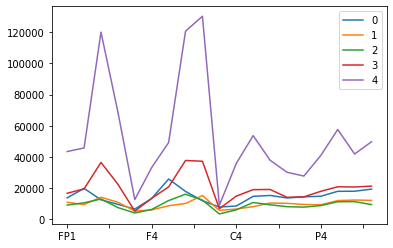

In [87]:
FFT_Processing(df)[4].

apply a fourier transform to the data in discrete sections so that you can get the average levels of each 

In [ ]:
# Seperate target and non-target for plotting
tar     = train_data[np.where(pd.Series(train_labels).apply(binarizer).to_numpy() == 1)[0], :, :]
non_tar = train_data[np.where(pd.Series(train_labels).apply(binarizer).to_numpy() == 0)[0], :, :]

print('We have %d target trials' % tar.shape[0])
print('We have %d non-target trials' % non_tar.shape[0])

# We'll take the average of all trials to create an averaged ERP
tar_avg     = np.mean(tar, 0)
non_tar_avg = np.mean(non_tar, 0)

# Define channel of interest and create an array of time points
chan = 'Cz' # let's plot Cz
ch = np.where(channels == chan)[0][0]
times = np.linspace(epoch_start, epoch_end, train_data.shape[1])

# Initialize plot and calculate min and max y value
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
min_y = min(np.min(tar_avg), np.min(non_tar_avg))
max_y = max(np.max(tar_avg), np.max(non_tar_avg))

# Plot x and y axes
plt.plot([np.min(times), np.max(times)], [0, 0], color='k');  # x-axis
plt.plot([0, 0], [min_y, max_y], color='k');                  # y-axis

# Plot our averaged ERPs
plt.plot(times, tar_avg[:, ch], 'b', linewidth=4)
plt.plot(times, non_tar_avg[:, ch], 'r', linewidth=4)

# Highlight the baseline window and window of interest of our ERP
baseline = patches.Rectangle([baseline_start, min_y], baseline_end, np.abs(min_y)+max_y, 
                             color='c', alpha=0.2)
erp_win = patches.Rectangle([erp_start, min_y], erp_end-erp_start, np.abs(min_y)+max_y, 
                             color='lime', alpha=0.3)

# Add our baseline and window of interest highlights
ax.add_patch(baseline)
ax.add_patch(erp_win)

# Manually create legends since patches will corrupt default handles
legend_ = [patches.Patch(color='b', label = 'Target (oddball)'),
           patches.Patch(color='r', label = 'Non-target (standard)')]

# Finalize plot and set a high DPI for a crisp, hi-res figure
plt.xlabel('Time (msec)');
plt.ylabel('Amplitude (A/D Units)');
plt.legend(handles=legend_, loc="upper right");
plt.title('Event Related Potentials at channel %s' % chan);
fig.set_dpi(216);
plt.show();

In [ ]:
# Let's compute the windowed means within erp_start and erp_end
num_points = 5; # we will divide our window into num_points means

# Define a simple windowed means function
def wm(x, start, end, num_points):
    num_trials = x.shape[0] # assumes first dem is numb observations
    w = np.round((start+end)/num_points).astype(int)
    y = np.zeros((num_points, x.shape[-1], num_trials)) # assumes num chans as last dimension
    for i in range(0, num_points):
        s = start + (w * i)
        e = end   + (w * i)
        y[i, :, :] = np.mean(x[:, s:e, :], 1).T
    return y

# Combine into a single train variable. Also create labels
X_train    = wm(train_data, erp_s, erp_e, num_points)
markers_train = np.vstack((train_labels, train_markers)).T
y = train_labels

# Now let's compute windowed means of our test data
X_test = wm(test_data, erp_s, erp_e, num_points)
markers_test = test_markers

# Let's print out the shapes of our data
print('X_train shape is: ' + str(X_train.shape))
print('y shape is......: ' + str(y.shape))
print('X_test shape is.: ' + str(X_test.shape))

In [ ]:
# Since our X is 3D, we must flatten our data. We will then transpose it for sklearn
X_train = X_train.reshape(-1, X_train.shape[-1]).T
X_test = X_test.reshape(-1, X_test.shape[-1]).T

# Let's print out the new shape
print('X_train shape is now: ' + str(X_train.shape))
print('X_test  shape is now: ' + str(X_test.shape))

In [ ]:
# Train our classifier (this may take a while via JupyterHub)
clf_lsqrs = LinearDiscriminantAnalysis(solver = 'lsqr',  shrinkage = 'auto').fit(X_train, y)

In [ ]:
# Let's do 5-fold cross validation
score_lsqrs = cross_val_score(clf_lsqrs.fit(X_train, y), X_train, y, cv = 5)

# We will print out the mean score
print("solver = lsqr  accuracy: %f" % np.mean(score_lsqrs))